###  02. Neural Network Classification

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options) 


#### Make classification data and prepare it

In [1]:
from sklearn.datasets import make_circles

In [2]:
# Make 1000 Samples
from sklearn.datasets import make_circles
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f'First 5 Samples of X:\n{X[:5]}\n')
print(f'First 5 Samples of y:\n{y[:5]}\n')

First 5 Samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 Samples of y:
[1 1 1 1 0]



y is binary classification --> 0 or 1

In [5]:
# Make DataFrame of circle data
from turtle import circle
import pandas as pd


circles = pd.DataFrame({"X1" : X[:,0], 
                        "X2" : X[:,1], 
                        "label" : y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


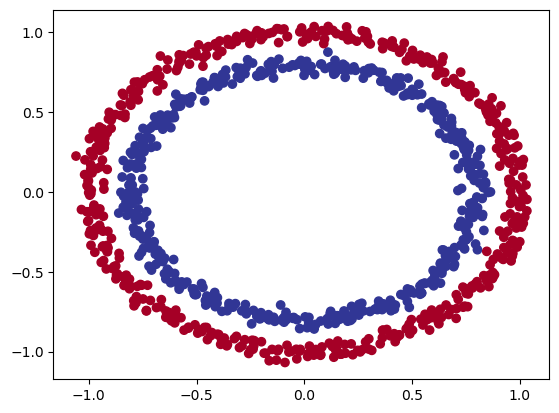

In [6]:
# Visualize the data 
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], 
            y=X[:,1], 
            c=y, 
            cmap=plt.cm.RdYlBu)


Note: The data we're working with is often called "toy data" or "synthetic data" because it's data we make up to try and mimic real-world data. It is small enough to experiment with but still sizeable enough to practice the fundamentals

#### Check input and output shapes

In [7]:
import torch
X.shape, y.shape

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)

y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]



(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split the data into train and test sets (use a random split)

from sklearn.model_selection import train_test_split


def split_data(X, y):
    return train_test_split(X, 
                            y, 
                            test_size=0.2, # 20% of data goes to test set 
                            random_state=42)

X_train, X_test, y_train, y_test = split_data(X, y)


In [9]:
# Check the length of the train and test data
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Build a model

Build a model to classify the dots / data

To do:
1. Set up device agnostic code so our code will run on GPU if available
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and testing loop


In [10]:
# Set up device agnostic code
import torch 
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

##### Construct a model class

Now that device agnostic code is set up, create a model that

1. Subclasses `nn.Module` (Pretty much every model subclasses `nn.Module`)
2. Create 2 `nn.Linear()` layers capable of handling shapes of data(Am I using the Kernel Trick?)
3. Define a `forward()` method that outline the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to the target `device`


In [11]:
# Construct a model that subclasses the nn.Module PyTorch class

import torch.nn as nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 linear layers using nn.Linear which can handle the data
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # how many neurons
        self.layer_2 = nn.Linear(in_features=8, out_features=1) # how many neurons (in_features must match previous out_features)
    
    # Define the forward pass of the model
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x --> layer 1 --> layer 2 --> output
    
# Instantiate an instance of our model class and send it to the target device
model_1 = CircleModelV1().to(device)
model_1 


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [12]:
# Check the target device
device

# Check to see where the model's parameters are
next(model_1.parameters()).device

device(type='cuda', index=0)

In [13]:
# Replicating the model using nn.Sequential()

import torch.nn as nn
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1).to(device)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [14]:
# Make some predictions with the model

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4637,  0.1833],
                      [-0.0590, -0.3957],
                      [ 0.0741, -0.2022],
                      [ 0.5296, -0.1993],
                      [ 0.4200,  0.1079],
                      [ 0.1959, -0.5578],
                      [ 0.3557,  0.5131],
                      [ 0.0445,  0.4734]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3588,  0.1505,  0.6987,  0.2527,  0.4147,  0.1253,  0.2320,  0.2491],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.2765,  0.2857,  0.0107, -0.0568,  0.0621,  0.2790,  0.1819,  0.3255]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.2828], device='cuda:0'))])

In [15]:
# Make untrained predictions
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))
print(f"length of untrained_preds: {len(untrained_preds)} Shape: {untrained_preds.shape}")
print(f'Length of test sample: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 Predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 Labels:\n{y_test[:10]}')

length of untrained_preds: 200 Shape: torch.Size([200, 1])
Length of test sample: 200, Shape: torch.Size([200, 2])

First 10 Predictions:
tensor([[ 0.0036],
        [-0.0176],
        [ 0.0643],
        [-0.0136],
        [ 0.0724],
        [ 0.0595],
        [-0.0067],
        [ 0.0114],
        [ 0.0638],
        [-0.0189]], device='cuda:0')

First 10 Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Pick a loss function and optimizer

Use the `torch.nn.functional.binary_cross_entropy` loss function
(input, target, weight=None, size_average=None, reduce=None, reduction='mean')



In [16]:
import torch.nn.functional as F
import torch


loss_fn = F.binary_cross_entropy_with_logits
# We use binary cross entropy with logits because our model is giving us logits (raw predictions) and not probabilities,
# This allows up to have some form of numerical stability when calculating the loss

optimizer = torch.optim.Adam(model_1.parameters(), 
                            lr=0.001)

# Calculating accuracy - out of 100 examples, what percentage did we get correct?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Training Loop

1. Forward propagation
2. Calculate the loss
3. Optimzer Zero Grad
4. Backpropagation
5. Optimizer step (gradient descent)


### From: Raw Logits --> Predictions Probabilities --> Class Labels

Our model outputs are going to be raw **logits**.

We convert these **logits** into prediction probabilities by passing them to some kind of activation function (sigmoid for binary classification and softmax for multiclass classification problem)

Then we can convert our model's prediction proabilities by either rounding them or taking the argmax()

In [17]:
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[ 0.0036],
        [-0.0176],
        [ 0.0643],
        [-0.0136],
        [ 0.0724]], device='cuda:0')

In [18]:
# Use the sigmoid activation function to transform logits to probabilities
y_pred_probs = F.sigmoid(y_logits)
y_pred_probs

tensor([[0.5009],
        [0.4956],
        [0.5161],
        [0.4966],
        [0.5181]], device='cuda:0')

For our prediction probability values, we need to perform a range style rounding on them:
* `y_pre_probs` >= 0.5, `y=1` (Class 1)
* `y_pre_probs` < 0.5, `y=0` (Class 0)

In [19]:
y_preds = torch.round(y_pred_probs)

with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_1(
                                        X_test.to(device))[:5]))
    
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze(),

tensor([True, True, True, True, True], device='cuda:0')


(tensor([1., 0., 1., 0., 1.], device='cuda:0'),)

### Building a training loop


In [24]:
# Import dependencies

from re import M
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set device
# Setting the training and testing data as device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create a testing loop to train the model
# 1. For an epoch in a range
# 2. Call model.train() to set the model to training mode
# 3. Do the forward pass of the model
# 4. Calculate the loss
# 5. Call model.zero_grad() to clear the gradients
# 6. Optimizer.step() to update the model parameters

MODEL = model_1
epochs = 100
LR = 0.001
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)

# Reshape the tensors to match [800, 1]


for epoch in range (epochs):
    ##### TRAINING #####
    MODEL.train()
    
    #1. Do the forward pass
    y_logits = MODEL(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate the loss / accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_preds)
    
    # Optimizer zero grad
    OPTIMIZER.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update the parameters
    OPTIMIZER.step()
    
    ##### Testing #####
    MODEL.eval()
    with torch.inference_mode():
        
        # Forward Pass
        y_test_logits = MODEL(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(y_test_logits))
        
        # Calculate the loss / accuracy
        test_loss = loss_fn(y_test_logits, 
                            y_test)
        test_acc = accuracy_fn(y_test,
                            test_preds)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"""
        Epoch: {epoch}
        Train loss: {loss:.4f} Train Acc: {acc:.2f}%
        Test loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%
        """)
    


        Epoch: 1/100
        Train loss: 0.6930 Train Acc: 51.00%
        Test loss: 0.6946 Test Acc: 46.00%
        

        Epoch: 11/100
        Train loss: 0.6930 Train Acc: 51.00%
        Test loss: 0.6946 Test Acc: 45.50%
        

        Epoch: 21/100
        Train loss: 0.6930 Train Acc: 51.25%
        Test loss: 0.6947 Test Acc: 46.00%
        

        Epoch: 31/100
        Train loss: 0.6930 Train Acc: 51.25%
        Test loss: 0.6947 Test Acc: 45.50%
        

        Epoch: 41/100
        Train loss: 0.6930 Train Acc: 51.12%
        Test loss: 0.6947 Test Acc: 46.00%
        

        Epoch: 51/100
        Train loss: 0.6930 Train Acc: 51.12%
        Test loss: 0.6947 Test Acc: 46.00%
        

        Epoch: 61/100
        Train loss: 0.6930 Train Acc: 51.12%
        Test loss: 0.6947 Test Acc: 46.00%
        

        Epoch: 71/100
        Train loss: 0.6930 Train Acc: 51.00%
        Test loss: 0.6947 Test Acc: 46.00%
        

        Epoch: 81/100
        Train loss

## 4. Make predictions and evaluate the model ##

From the metrics it looks like the model is not learning anuything

Let's make the data visual

To do so, use `plot_decision_boundary()`

In [29]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo (if not already downloaded)
if Path('helper_functions.py').is_file() != True:
    url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'
    r = requests.get(url)
    with open('helper_functions.py', 'w') as f:
        f.write(r.text)
        
from helper_functions import plot_predictions, plot_decision_boundary

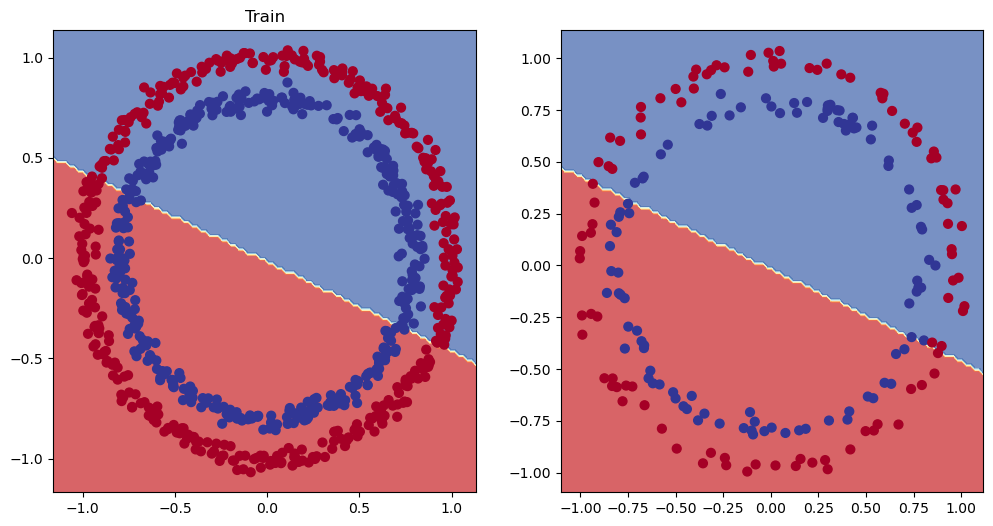

In [31]:
# Plot decision boundary of the model
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_1,
                        X=X_train,
                        y=y_train)

plt.subplot(1, 2, 2)
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

### Improving the model (from a model perspective)

* Add more layers - gives the models more chances to learn about specific patterns in the data
* Add more neurons in the hidden layers 
* Add more epochs
* Changing the activation functions
* Change the learning rate

These options are all from the model's perspective because these are variables that can be changed within the model architecture

Improve the model by:
* Adding more hidden neurons 8 -> 512
* Adding more layers 2-> 5
* Increase the number of epochs 100-> 1000

**Typically** only change one variable at a time

In [40]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)

# Create a new model with different hyperparameters
class CircleModelV2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Create a model
        self.layer_1 = nn.Linear(2, 512)
        self.layer_2 = nn.ReLU()
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.ReLU()
        self.layer_5 = nn.Linear(256, 1)
    
    def forward(self, x):
        return self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))
    
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): ReLU()
  (layer_5): Linear(in_features=256, out_features=1, bias=True)
)

In [41]:
# Create a loss function
import torch
loss_fn = F.binary_cross_entropy_with_logits

# Create an optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Write a training loop and evaluation loop for model_2

epochs = 100
LR = 0.001
OPTIMIZER = optim.Adam(model_2.parameters(), lr=LR)

for epoch in range(epochs):
    ### TRAINING ###
    model_2.train()
    
    # Forward pass
    y_preds = model_2(X_train).squeeze()
    
    # Calculate loss
    loss = loss_fn(y_preds, y_train)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    ### EVALUATION ###
    model_2.eval()
    
    # Forward pass
    with torch.inference_mode():
        y_preds = model_2(X_test).squeeze()
        
        # Calculate loss
        test_loss = loss_fn(y_preds, y_test)
    
    # Print the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.69531 | Test Loss: 0.69165
Epoch: 10 | Loss: 0.59336 | Test Loss: 0.59700
Epoch: 20 | Loss: 0.44246 | Test Loss: 0.45257
Epoch: 30 | Loss: 0.26408 | Test Loss: 0.28317
Epoch: 40 | Loss: 0.13075 | Test Loss: 0.15500
Epoch: 50 | Loss: 0.06319 | Test Loss: 0.08533
Epoch: 60 | Loss: 0.03467 | Test Loss: 0.05383
Epoch: 70 | Loss: 0.02208 | Test Loss: 0.03875
Epoch: 80 | Loss: 0.01580 | Test Loss: 0.03062
Epoch: 90 | Loss: 0.01218 | Test Loss: 0.02549


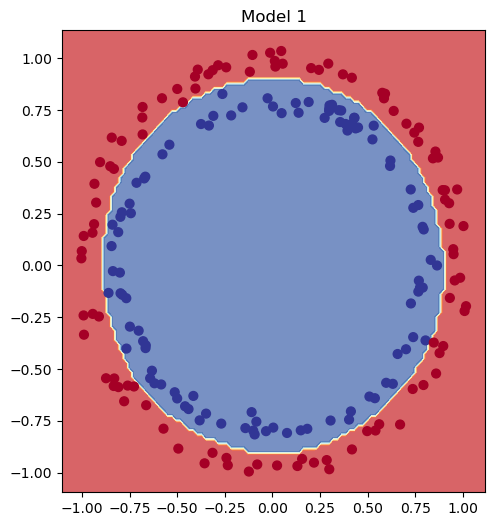

In [42]:
# Plot the decision boundary of model_2

import matplotlib.pyplot as plt

# Use helper function to plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Model 1')
plot_decision_boundary(model=model_2,
                        X=X_test, 
                        y=y_test)

